### Imports & Helper Funcs

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='ticks')
sns.set_context('paper')

In [2]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the input DataFrame by removing columns with more than 50% missing values 
    and rows with any missing values.

    Parameters
    -
    data (pd.DataFrame): The input DataFrame to be cleaned.

    Returns
    -
    pd.DataFrame: The cleaned DataFrame with no missing values.
    
    Prints:
    - The original shape of the DataFrame.
    - The number of missing values in the original DataFrame.
    - The shape of the DataFrame after cleaning.
    """
    print(f'Original Shape: {data.shape}')
    print(f'Number of missing values: {data.isna().sum().sum()}')

    if data.notna().all().all():
        return data

    data = data.dropna(axis=1, thresh=len(data)*.5)
    data = data.dropna()

    print(f'Cleaned Shape: {data.shape}')
    return data

In [3]:
def aggregate_gdf_data(
    left_gdf: gpd.GeoDataFrame,
    right_gdf: gpd.GeoDataFrame,
    target: str,
    predicate: str,
    cols_to_sum: list,
    cols_to_average: list
) -> gpd.GeoDataFrame:
    """
    Aggregates data from two GeoDataFrames based on spatial join and specified columns.

    Parameters
    -
    left_gdf (gpd.GeoDataFrame): The left GeoDataFrame to join.
    right_gdf (gpd.GeoDataFrame): The right GeoDataFrame to join.
    target (str): The target column name to group by.
    predicate (str): The spatial predicate to use for the join (e.g., 'intersects', 'within').
    cols_to_sum (list): List of column names to sum during aggregation.
    cols_to_average (list): List of column names to average during aggregation.

    Returns
    -
    gpd.GeoDataFrame: A GeoDataFrame with aggregated data.
    """
    assert left_gdf.notna().all().all(), 'Left GeoDataFrame contains missing values'
    assert right_gdf.notna().all().all(), 'Right GeoDataFrame contains missing values'
    assert left_gdf.crs == right_gdf.crs, 'CRS mismatch'

    agg_dict = {col: 'sum' for col in cols_to_sum}
    agg_dict.update({col: 'mean' for col in cols_to_average})

    gdf = left_gdf.sjoin(right_gdf, how='inner', predicate=predicate)
    gdf = gdf.groupby(target).agg(agg_dict)
    gdf = left_gdf.merge(gdf, left_on=target, right_index=True, how='left')
    
    return gdf   

In [4]:
def encode_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encodes categorical columns in a DataFrame.
    This function processes all categorical columns in the given DataFrame.
    For ordered categorical columns, it replaces them with their respective
    category codes. For unordered categorical columns, it creates dummy/indicator
    variables and drops the first category to avoid multicollinearity.
    
    Parameters
    -
    df (pandas.DataFrame): The input DataFrame containing categorical columns.
    
    Returns
    -
    pandas.DataFrame: The DataFrame with encoded categorical columns.
    """
    cat_cols = df.select_dtypes(include=['category']).columns

    for col in cat_cols:
        if df[col].cat.ordered:
            df[col] = df[col].cat.codes
        else:
            df = pd.get_dummies(df, columns=[col], drop_first=True)
            
    return df

### Import and Clean Data

#### Zones

In [5]:
gdf_zones = gpd.read_file('../OD-2017/od_zonas.zip', layer='Zonas_2017_region')
gdf_zones.head()

,NumeroZona,NomeZona,NumeroMuni,NomeMunici,NumDistrit,NomeDistri,Area_ha_2,geometry
0,1,Sé,36,São Paulo,80,Sé,57.10,"POLYGON Z ((333739.415 7394619.838 0, 333792.4..."
1,2,Parque Dom Pedro,36,São Paulo,80,Sé,113.64,"POLYGON Z ((333106.146 7395425.48 0, 333120.09..."
2,3,Praça João Mendes,36,São Paulo,80,Sé,47.75,"POLYGON Z ((333353.211 7393933.156 0, 333238.0..."
3,4,Ladeira da Memória,36,São Paulo,67,República,75.11,"POLYGON Z ((332742.619 7394795.328 0, 332742.5..."
4,5,República,36,São Paulo,67,República,74.95,"POLYGON Z ((332983.962 7395262.578 0, 333004.2..."


In [6]:
gdf_zones.crs

<Projected CRS: EPSG:22523>
Name: Corrego Alegre 1970-72 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - onshore between 48°W and 42°W and south of 15°S.
- bounds: (-48.0, -25.29, -42.0, -15.0)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Corrego Alegre 1970-72
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [7]:
gdf_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NumeroZona  517 non-null    int64   
 1   NomeZona    517 non-null    object  
 2   NumeroMuni  517 non-null    int64   
 3   NomeMunici  517 non-null    object  
 4   NumDistrit  517 non-null    int64   
 5   NomeDistri  517 non-null    object  
 6   Area_ha_2   517 non-null    float64 
 7   geometry    517 non-null    geometry
dtypes: float64(1), geometry(1), int64(3), object(3)
memory usage: 32.4+ KB


In [8]:
# change gdf_zones int64 columns to object

gdf_zones = gdf_zones.astype({'NumeroZona': 'object', 'NumeroMuni': 'object', 'NumDistrit': 'object'})
gdf_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NumeroZona  517 non-null    object  
 1   NomeZona    517 non-null    object  
 2   NumeroMuni  517 non-null    object  
 3   NomeMunici  517 non-null    object  
 4   NumDistrit  517 non-null    object  
 5   NomeDistri  517 non-null    object  
 6   Area_ha_2   517 non-null    float64 
 7   geometry    517 non-null    geometry
dtypes: float64(1), geometry(1), object(6)
memory usage: 32.4+ KB


<Axes: >

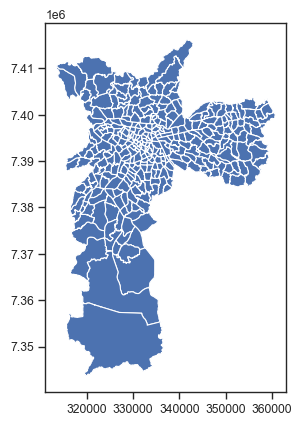

In [9]:
# filter only zones in the city of São Paulo

gdf_zones = gdf_zones[gdf_zones['NomeMunici'] == 'São Paulo']
gdf_zones.plot()

In [10]:
gdf_zones = clean_data(gdf_zones)

Original Shape: (342, 8)
Number of missing values: 0


In [11]:
sp_zones = gdf_zones["NumeroZona"].to_list()

#### Census IBGE 2010

In [12]:
df_census = pd.read_parquet('../GENERATED-DATA/census.parquet')
df_census.columns, df_census.shape

(Index(['CD_GEOCODI', 'V001_ENTORNO01', 'V002_ENTORNO01', 'V003_ENTORNO01',
        'V004_ENTORNO01', 'V001_DOMICILIORENDA', 'V002_DOMICILIORENDA',
        'V003_DOMICILIORENDA', 'V004_DOMICILIORENDA', 'V001_BASICO',
        'V002_BASICO', 'V003_BASICO', 'V004_BASICO', 'V005_BASICO',
        'V006_BASICO', 'V007_BASICO', 'V008_BASICO', 'V009_BASICO',
        'V010_BASICO', 'V011_BASICO', 'V012_BASICO', 'V001_DOMICILIO02',
        'V002_DOMICILIO02', 'V001_DOMICILIO01', 'V002_DOMICILIO01',
        'V001_PESSOA01', 'V086_PESSOA02', 'V001_PESSOA03', 'V002_PESSOA03',
        'V003_PESSOA03', 'V004_PESSOA03', 'V005_PESSOA03', 'V006_PESSOA03',
        'V001_PESSOA12', 'V001_PESSOA11', 'V001_RESPONSAVEL01',
        'V001_RESPONSAVEL02'],
       dtype='object'),
 (18363, 37))

In [13]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18363 entries, 0 to 18362
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CD_GEOCODI           18363 non-null  object 
 1   V001_ENTORNO01       18206 non-null  float64
 2   V002_ENTORNO01       18206 non-null  float64
 3   V003_ENTORNO01       18206 non-null  float64
 4   V004_ENTORNO01       18206 non-null  float64
 5   V001_DOMICILIORENDA  18206 non-null  float64
 6   V002_DOMICILIORENDA  18206 non-null  float64
 7   V003_DOMICILIORENDA  18206 non-null  float64
 8   V004_DOMICILIORENDA  18206 non-null  float64
 9   V001_BASICO          18333 non-null  float64
 10  V002_BASICO          18333 non-null  float64
 11  V003_BASICO          18333 non-null  float64
 12  V004_BASICO          18333 non-null  float64
 13  V005_BASICO          18333 non-null  float64
 14  V006_BASICO          18333 non-null  float64
 15  V007_BASICO          18324 non-null 

In [14]:
# transform int64 columns to float64

int64_cols = df_census.select_dtypes(include=['int64']).columns
df_census[int64_cols] = df_census[int64_cols].astype('float64')
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18363 entries, 0 to 18362
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CD_GEOCODI           18363 non-null  object 
 1   V001_ENTORNO01       18206 non-null  float64
 2   V002_ENTORNO01       18206 non-null  float64
 3   V003_ENTORNO01       18206 non-null  float64
 4   V004_ENTORNO01       18206 non-null  float64
 5   V001_DOMICILIORENDA  18206 non-null  float64
 6   V002_DOMICILIORENDA  18206 non-null  float64
 7   V003_DOMICILIORENDA  18206 non-null  float64
 8   V004_DOMICILIORENDA  18206 non-null  float64
 9   V001_BASICO          18333 non-null  float64
 10  V002_BASICO          18333 non-null  float64
 11  V003_BASICO          18333 non-null  float64
 12  V004_BASICO          18333 non-null  float64
 13  V005_BASICO          18333 non-null  float64
 14  V006_BASICO          18333 non-null  float64
 15  V007_BASICO          18324 non-null 

In [15]:
df_census = clean_data(df_census)

Original Shape: (18363, 37)
Number of missing values: 2635
Cleaned Shape: (18182, 37)


In [16]:
gdf_census = gpd.read_file('../CENSO-2010/sp_setores_censitarios.zip')
gdf_census.columns, gdf_census.shape

(Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODS', 'NM_SUBDIST', 'CD_GEOCODD',
        'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP', 'NM_MICRO', 'NM_MESO',
        'CD_GEOCODB', 'NM_BAIRRO', 'ID1', 'geometry'],
       dtype='object'),
 (68296, 15))

In [17]:
gdf_census.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
# filter gdf_census to only include census tracts in the city of São Paulo

gdf_census = gdf_census[gdf_census['NM_MUNICIP'] == 'SÃO PAULO']
gdf_census.shape

(18953, 15)

In [19]:
gdf_census = clean_data(gdf_census)

Original Shape: (18953, 15)
Number of missing values: 56859
Cleaned Shape: (18953, 12)


In [20]:
gdf_census = gdf_census.to_crs(epsg=22523)
gdf_census.crs

<Projected CRS: EPSG:22523>
Name: Corrego Alegre 1970-72 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - onshore between 48°W and 42°W and south of 15°S.
- bounds: (-48.0, -25.29, -42.0, -15.0)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Corrego Alegre 1970-72
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [21]:
gdf_census = gdf_census.drop(columns=['ID', 'ID1'])
gdf_census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 18953 entries, 42322 to 62384
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CD_GEOCODI  18953 non-null  object  
 1   TIPO        18953 non-null  object  
 2   CD_GEOCODS  18953 non-null  object  
 3   CD_GEOCODD  18953 non-null  object  
 4   NM_DISTRIT  18953 non-null  object  
 5   CD_GEOCODM  18953 non-null  object  
 6   NM_MUNICIP  18953 non-null  object  
 7   NM_MICRO    18953 non-null  object  
 8   NM_MESO     18953 non-null  object  
 9   geometry    18953 non-null  geometry
dtypes: geometry(1), object(9)
memory usage: 1.6+ MB


In [22]:
# merge df_census data into gdf_census, keep only tracts with data (inner join)

gdf_census = gdf_census.merge(df_census, left_on='CD_GEOCODI', right_on='CD_GEOCODI', how='inner')
gdf_census.columns, gdf_census.shape

(Index(['CD_GEOCODI', 'TIPO', 'CD_GEOCODS', 'CD_GEOCODD', 'NM_DISTRIT',
        'CD_GEOCODM', 'NM_MUNICIP', 'NM_MICRO', 'NM_MESO', 'geometry',
        'V001_ENTORNO01', 'V002_ENTORNO01', 'V003_ENTORNO01', 'V004_ENTORNO01',
        'V001_DOMICILIORENDA', 'V002_DOMICILIORENDA', 'V003_DOMICILIORENDA',
        'V004_DOMICILIORENDA', 'V001_BASICO', 'V002_BASICO', 'V003_BASICO',
        'V004_BASICO', 'V005_BASICO', 'V006_BASICO', 'V007_BASICO',
        'V008_BASICO', 'V009_BASICO', 'V010_BASICO', 'V011_BASICO',
        'V012_BASICO', 'V001_DOMICILIO02', 'V002_DOMICILIO02',
        'V001_DOMICILIO01', 'V002_DOMICILIO01', 'V001_PESSOA01',
        'V086_PESSOA02', 'V001_PESSOA03', 'V002_PESSOA03', 'V003_PESSOA03',
        'V004_PESSOA03', 'V005_PESSOA03', 'V006_PESSOA03', 'V001_PESSOA12',
        'V001_PESSOA11', 'V001_RESPONSAVEL01', 'V001_RESPONSAVEL02'],
       dtype='object'),
 (18182, 46))

In [23]:
# double checking for missing values

gdf_census.isna().sum().sum()

np.int64(0)

#### Metro-SP OD 2017

In [24]:
df_od = pd.read_spss('../OD-2017/od_dados/OD_2017_v1.sav')
df_od.columns, df_od.shape

(Index(['zona', 'muni_dom', 'co_dom_x', 'co_dom_y', 'id_dom', 'f_dom', 'fe_dom',
        'dom', 'cd_entre', 'data',
        ...
        'modoprin', 'tipvg', 'pag_viag', 'tp_esauto', 'vl_est', 'pe_bici',
        'via_bici', 'tp_esbici', 'distancia', 'id_ordem'],
       dtype='object', length=128),
 (183092, 128))

In [25]:
# filter only relevant features

cols_to_keep = [
    'idade',
    'sexo',
    'estuda',
    'grau_ins',
    'cd_ativi',
    'co_ren_i',
    #'vl_ren_i',
    'motivo_o',
    'motivo_d',
    #'co_d_x',
    #'co_d_y',
    #'zona_o',
    'zona_d',
]

df_od = df_od[cols_to_keep]

In [26]:
# filter only trips to the city of São Paulo

df_od = df_od[df_od['zona_d'].isin(sp_zones)]
df_od.shape

(112265, 9)

<Axes: >

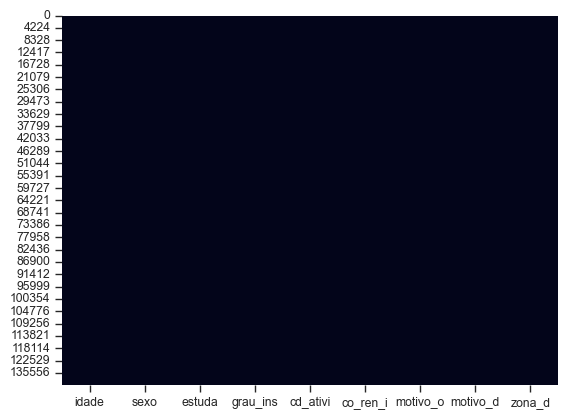

In [27]:
sns.heatmap(df_od.isna(), cbar=False)

In [28]:
df_od = clean_data(df_od)

Original Shape: (112265, 9)
Number of missing values: 0


#### Crime Data

In [29]:
df_crime = pd.read_csv("../GENERATED-DATA/crime_2017-2018_clean.csv")
df_crime.columns, df_crime.shape

(Index(['LATITUDE', 'LONGITUDE'], dtype='object'), (811092, 2))

In [30]:
pt_geoms = gpd.points_from_xy(
    x=df_crime["LONGITUDE"],
    y=df_crime["LATITUDE"],
    crs="EPSG:4674",
)

gdf_crime = gpd.GeoDataFrame(geometry=pt_geoms)
gdf_crime.columns, gdf_crime.shape

(Index(['geometry'], dtype='object'), (811092, 1))

In [31]:
gdf_crime = gdf_crime.to_crs(epsg=22523)

### Aggregate Data

#### Census IBGE 2010

##### Define aggregation metrics

In [32]:
gdf_census.columns

Index(['CD_GEOCODI', 'TIPO', 'CD_GEOCODS', 'CD_GEOCODD', 'NM_DISTRIT',
       'CD_GEOCODM', 'NM_MUNICIP', 'NM_MICRO', 'NM_MESO', 'geometry',
       'V001_ENTORNO01', 'V002_ENTORNO01', 'V003_ENTORNO01', 'V004_ENTORNO01',
       'V001_DOMICILIORENDA', 'V002_DOMICILIORENDA', 'V003_DOMICILIORENDA',
       'V004_DOMICILIORENDA', 'V001_BASICO', 'V002_BASICO', 'V003_BASICO',
       'V004_BASICO', 'V005_BASICO', 'V006_BASICO', 'V007_BASICO',
       'V008_BASICO', 'V009_BASICO', 'V010_BASICO', 'V011_BASICO',
       'V012_BASICO', 'V001_DOMICILIO02', 'V002_DOMICILIO02',
       'V001_DOMICILIO01', 'V002_DOMICILIO01', 'V001_PESSOA01',
       'V086_PESSOA02', 'V001_PESSOA03', 'V002_PESSOA03', 'V003_PESSOA03',
       'V004_PESSOA03', 'V005_PESSOA03', 'V006_PESSOA03', 'V001_PESSOA12',
       'V001_PESSOA11', 'V001_RESPONSAVEL01', 'V001_RESPONSAVEL02'],
      dtype='object')

In [33]:
cols_to_sum = [
    'V001_ENTORNO01', 'V002_ENTORNO01', 'V003_ENTORNO01', 'V004_ENTORNO01', # n domicílios permanentes
    'V001_DOMICILIORENDA', # n domicilios improvisados
    'V001_BASICO', 'V002_BASICO', # n domicilios, moradores em domicílios permanentes
    'V001_DOMICILIO02', 'V002_DOMICILIO02', # n domicilios coletivos
    'V001_DOMICILIO01', 'V002_DOMICILIO01',
    'V001_PESSOA01', # n pessoas alfabetizadass
    'V086_PESSOA02', # n mulheres alfabetizadas
    'V001_PESSOA03', 'V002_PESSOA03', 'V003_PESSOA03',
    'V004_PESSOA03', 'V005_PESSOA03', 'V006_PESSOA03', # n pessoas residentes (diferentes cores)
    'V001_PESSOA12', # n mulheres residentes
    'V001_PESSOA11', # n homens residentes
    'V001_RESPONSAVEL01', # n pessoas responsaveis, sexo feminino
    'V001_RESPONSAVEL02', # n pessoas responsaveis
]

cols_to_average = [
    'V002_DOMICILIORENDA', 'V003_DOMICILIORENDA', 'V004_DOMICILIORENDA',  # valores de renda media com algumas variações de tipo de domicílio
    'V003_BASICO', # n medio de pessoas por domicilio
    'V005_BASICO', # valor medio de renda de todos
    'V007_BASICO', # valor medio de renda de quem tem renda
    'V009_BASICO', # valor medio de renda de todos acima de 10 anos
    'V011_BASICO', # valor medio de renda de todos acima de 10 anos, com rendimento
]

##### Aggregate

In [34]:
gdf = aggregate_gdf_data(
    gdf_zones,
    gdf_census,
    'NumeroZona',
    'intersects',
    cols_to_sum,
    cols_to_average,
)

gdf.shape

(342, 39)

In [35]:
gdf[gdf.isna().any(axis=1)].shape # rows with missing values

(0, 39)

<Axes: >

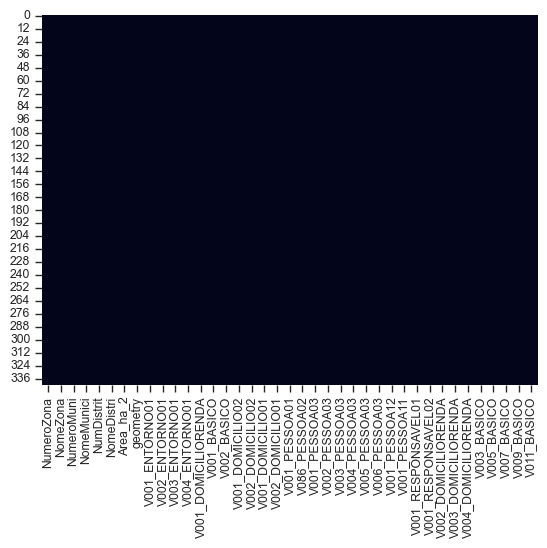

In [36]:
sns.heatmap(gdf.isna(), cbar=False)

In [37]:
gdf.columns

Index(['NumeroZona', 'NomeZona', 'NumeroMuni', 'NomeMunici', 'NumDistrit',
       'NomeDistri', 'Area_ha_2', 'geometry', 'V001_ENTORNO01',
       'V002_ENTORNO01', 'V003_ENTORNO01', 'V004_ENTORNO01',
       'V001_DOMICILIORENDA', 'V001_BASICO', 'V002_BASICO', 'V001_DOMICILIO02',
       'V002_DOMICILIO02', 'V001_DOMICILIO01', 'V002_DOMICILIO01',
       'V001_PESSOA01', 'V086_PESSOA02', 'V001_PESSOA03', 'V002_PESSOA03',
       'V003_PESSOA03', 'V004_PESSOA03', 'V005_PESSOA03', 'V006_PESSOA03',
       'V001_PESSOA12', 'V001_PESSOA11', 'V001_RESPONSAVEL01',
       'V001_RESPONSAVEL02', 'V002_DOMICILIORENDA', 'V003_DOMICILIORENDA',
       'V004_DOMICILIORENDA', 'V003_BASICO', 'V005_BASICO', 'V007_BASICO',
       'V009_BASICO', 'V011_BASICO'],
      dtype='object')

#### Metro-SP OD 2017

##### Prepare Categorical Features for Aggregation

In [38]:
df_od.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112265 entries, 0 to 183071
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   idade     112265 non-null  float64 
 1   sexo      112265 non-null  category
 2   estuda    112265 non-null  category
 3   grau_ins  112265 non-null  category
 4   cd_ativi  112265 non-null  category
 5   co_ren_i  112265 non-null  category
 6   motivo_o  112265 non-null  category
 7   motivo_d  112265 non-null  category
 8   zona_d    112265 non-null  float64 
dtypes: category(7), float64(2)
memory usage: 3.3 MB


In [39]:
cat_cols = df_od.select_dtypes(include=['category']).columns.tolist()
for col in cat_cols:
    print(f'{col}: {df_od[col].cat.categories.tolist()}')

sexo: ['Feminino', 'Masculino']
estuda: ['1º grau/ Fundamental', '2º grau/ Médio', 'Creche/ Pré-escola', 'Não', 'Outros', 'Superior/ Universitário']
grau_ins: ['Fundamental I Completo/ Fundamental II Incompleto', 'Fundamental II Completo/ Médio Incompleto', 'Médio Completo/ Superior Incompleto', 'Não Alfabetizado/ Fundamental I Incompleto', 'Superior Completo']
cd_ativi: ['Aposentado/ Pensionista', 'Dona de Casa', 'Em Licença Médica', 'Estudante', 'Faz Bico', 'Nunca Trabalhou', 'Sem Trabalho', 'Tem Trabalho Regular']
co_ren_i: ['Não respondeu', 'Não tem renda', 'Tem renda']
motivo_o: ['Assuntos Pessoais', 'Compras', 'Escola/Educação', 'Médico/Dentista/Saúde', 'Procurar Emprego', 'Recreação/Visitas/Lazer', 'Refeição', 'Residência', 'Trabalho Comércio', 'Trabalho Indústria', 'Trabalho Serviços']
motivo_d: ['Assuntos Pessoais', 'Compras', 'Escola/Educação', 'Médico/Dentista/Saúde', 'Procurar Emprego', 'Recreação/Visitas/Lazer', 'Refeição', 'Residência', 'Trabalho Comércio', 'Trabalho Indú

In [40]:
# grau_ins should be ordered

df_od['grau_ins'] = df_od['grau_ins'].cat.reorder_categories(
    [
        'Não Alfabetizado/ Fundamental I Incompleto',
        'Fundamental I Completo/ Fundamental II Incompleto',
        'Fundamental II Completo/ Médio Incompleto',
        'Médio Completo/ Superior Incompleto',
        'Superior Completo',
    ],
    ordered=True,
)

In [41]:
df_od = encode_categoricals(df_od)
df_od.columns

Index(['idade', 'grau_ins', 'zona_d', 'sexo_Masculino',
       'estuda_2º grau/ Médio', 'estuda_Creche/ Pré-escola', 'estuda_Não',
       'estuda_Outros', 'estuda_Superior/ Universitário',
       'cd_ativi_Dona de Casa', 'cd_ativi_Em Licença Médica',
       'cd_ativi_Estudante', 'cd_ativi_Faz Bico', 'cd_ativi_Nunca Trabalhou',
       'cd_ativi_Sem Trabalho', 'cd_ativi_Tem Trabalho Regular',
       'co_ren_i_Não tem renda', 'co_ren_i_Tem renda', 'motivo_o_Compras',
       'motivo_o_Escola/Educação', 'motivo_o_Médico/Dentista/Saúde',
       'motivo_o_Procurar Emprego', 'motivo_o_Recreação/Visitas/Lazer',
       'motivo_o_Refeição', 'motivo_o_Residência',
       'motivo_o_Trabalho Comércio', 'motivo_o_Trabalho Indústria',
       'motivo_o_Trabalho Serviços', 'motivo_d_Compras',
       'motivo_d_Escola/Educação', 'motivo_d_Médico/Dentista/Saúde',
       'motivo_d_Procurar Emprego', 'motivo_d_Recreação/Visitas/Lazer',
       'motivo_d_Refeição', 'motivo_d_Residência',
       'motivo_d_Traba

##### Aggregate

In [42]:
len(sp_zones)

342

In [43]:
df_od.columns

Index(['idade', 'grau_ins', 'zona_d', 'sexo_Masculino',
       'estuda_2º grau/ Médio', 'estuda_Creche/ Pré-escola', 'estuda_Não',
       'estuda_Outros', 'estuda_Superior/ Universitário',
       'cd_ativi_Dona de Casa', 'cd_ativi_Em Licença Médica',
       'cd_ativi_Estudante', 'cd_ativi_Faz Bico', 'cd_ativi_Nunca Trabalhou',
       'cd_ativi_Sem Trabalho', 'cd_ativi_Tem Trabalho Regular',
       'co_ren_i_Não tem renda', 'co_ren_i_Tem renda', 'motivo_o_Compras',
       'motivo_o_Escola/Educação', 'motivo_o_Médico/Dentista/Saúde',
       'motivo_o_Procurar Emprego', 'motivo_o_Recreação/Visitas/Lazer',
       'motivo_o_Refeição', 'motivo_o_Residência',
       'motivo_o_Trabalho Comércio', 'motivo_o_Trabalho Indústria',
       'motivo_o_Trabalho Serviços', 'motivo_d_Compras',
       'motivo_d_Escola/Educação', 'motivo_d_Médico/Dentista/Saúde',
       'motivo_d_Procurar Emprego', 'motivo_d_Recreação/Visitas/Lazer',
       'motivo_d_Refeição', 'motivo_d_Residência',
       'motivo_d_Traba

In [44]:
# group by 'zona_d' and take the mean of all columns

df_od_agg = df_od.groupby('zona_d').mean()
df_od_agg['viagens'] = df_od.groupby('zona_d').size()

In [45]:
df_od_agg = clean_data(df_od_agg)

Original Shape: (338, 38)
Number of missing values: 0


In [46]:
df_od_agg['viagens'].describe()

count     338.000000
mean      332.144970
std       197.127848
min         1.000000
25%       212.000000
50%       273.500000
75%       387.750000
max      1287.000000
Name: viagens, dtype: float64

##### Merge With The GeoDataFrame

In [47]:
gdf = gdf.merge(df_od_agg, left_on='NumeroZona', right_index=True, how='left')
gdf.shape

(342, 77)

<Axes: >

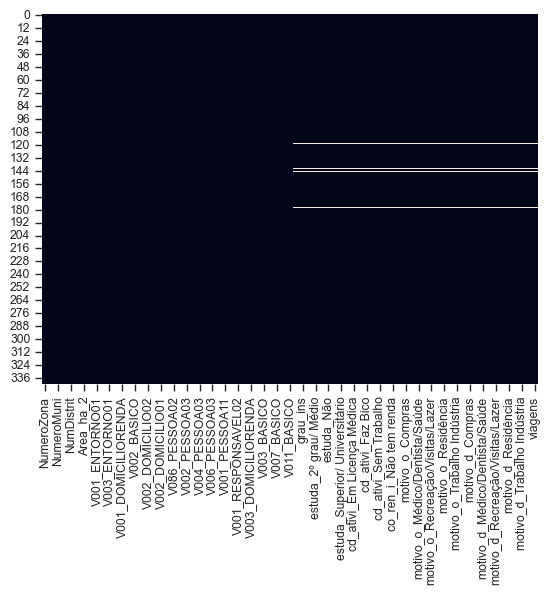

In [48]:
sns.heatmap(gdf.isna(), cbar=False)

In [49]:
gdf.viagens.isna().sum() # zones with no trips

np.int64(4)

#### Crime SP

In [50]:
gdf_crime.shape

(811092, 1)

In [51]:
gdf_crime = gdf_zones.sjoin(gdf_crime, how='inner', predicate='contains') # inner join so only zones with crimes are kept

In [52]:
gdf_crime.isna().sum()

NumeroZona     0
NomeZona       0
NumeroMuni     0
NomeMunici     0
NumDistrit     0
NomeDistri     0
Area_ha_2      0
geometry       0
index_right    0
dtype: int64

In [53]:
df_crime_agg = gdf_crime.groupby('NumeroZona').size()
df_crime_agg = df_crime_agg.to_frame(name='crimes')

In [54]:
df_crime_agg

,crimes
NumeroZona,
1,7092
2,5537
3,3718
4,4637
5,12866
...,...
338,1314
339,692
340,2690


In [55]:
# merge crime data into gdf

gdf = gdf.merge(df_crime_agg, left_on='NumeroZona', right_index=True, how='left')

In [56]:
gdf.isna().sum()

NumeroZona                     0
NomeZona                       0
NumeroMuni                     0
NomeMunici                     0
NumDistrit                     0
                              ..
motivo_d_Trabalho Comércio     4
motivo_d_Trabalho Indústria    4
motivo_d_Trabalho Serviços     4
viagens                        4
crimes                         2
Length: 78, dtype: int64

In [57]:
# rows with missing values

f'{gdf[gdf.isna().any(axis=1)].shape[0]} out of {gdf.shape[0]} zones have missing values'

'4 out of 342 zones have missing values'

### Save Final GeoDataFrame

In [58]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 342 entries, 0 to 341
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   NumeroZona                        342 non-null    object  
 1   NomeZona                          342 non-null    object  
 2   NumeroMuni                        342 non-null    object  
 3   NomeMunici                        342 non-null    object  
 4   NumDistrit                        342 non-null    object  
 5   NomeDistri                        342 non-null    object  
 6   Area_ha_2                         342 non-null    float64 
 7   geometry                          342 non-null    geometry
 8   V001_ENTORNO01                    342 non-null    float64 
 9   V002_ENTORNO01                    342 non-null    float64 
 10  V003_ENTORNO01                    342 non-null    float64 
 11  V004_ENTORNO01                    342 non-null    float

In [59]:
# save the final GeoDataFrame

gdf.to_file('../GENERATED-DATA/data_by_zone.geojson', driver='GeoJSON')